#### ■ Sample Code for Comparison of NRBdMF and NRLMF under CVS2
 In an ideal drug side effects prediction, the positive labels are enriched, and the negative labels are sparse in the top ranked predictions.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

import sys
sys.path.append('C:/github/NRBdMF')
import nrbdmf # import proposed method
from Representative_Methods.methods import nrlmf # import traditional method
from _utils import performance_compare as pc

base_dir = 'C:/github/NRBdMF' # clone directory

In [2]:
#%% load data
df = pd.read_csv(base_dir + '/Data/646x499/se_ind_merge_table.csv',index_col=0)
drugMat = pd.read_csv(base_dir + '/Data/646x499/dtinet_646x646_sim.csv',index_col=0)
diseaseMat = pd.read_csv(base_dir + '/Data/646x499/do_499x499_sim.csv',index_col=0)

# for validation
ind_bi = pd.read_csv(base_dir + '/Data/raw_rel/ind_1423x2154_binary.csv',index_col=0)
se_bi = pd.read_csv(base_dir + '/Data/raw_rel/se_1429x4138_binary.csv',index_col=0)
use_ind = ind_bi[df.columns.tolist()].loc[df.index.tolist()]
use_se = se_bi[df.columns.tolist()].loc[df.index.tolist()]

drug2name = pd.read_pickle(base_dir + '/Data/tools/sider_cid2name.pkl')
list(drug2name.keys())[0]
name2pt = pd.read_pickle(base_dir + '/Data/tools/pt_name2cui.pkl')
pt2name = dict(zip(list(name2pt.values()),list(name2pt.keys())))

drugs = df.index.tolist()
diseases = df.columns.tolist()

ann_ind = [drug2name.get(k) for k in drugs]
ann_col = [pt2name.get(k) for k in diseases]

# renae all columns and rows
df.index = ann_ind
df.columns = ann_col

drugMat.index = ann_ind
drugMat.columns = ann_ind

diseaseMat.index = ann_col
diseaseMat.columns = ann_col

use_ind.index = ann_ind
use_ind.columns = ann_col

use_se.index = ann_ind
use_se.columns = ann_col

***
#### ① NRBdMF (proposed method) 1/10-fold

GSVA like statistics (positive) 0.51744
GSVA like statistics (negative) -0.26409


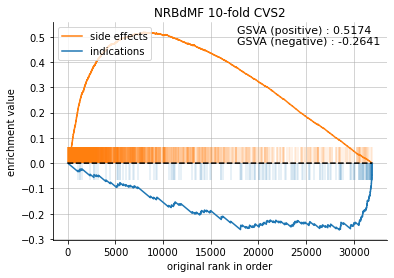

In [5]:
#%% NRBdMF
cv_data1 = pd.read_pickle(base_dir + '/Data/cvs_data/simple_CVS2_NRLMF.pkl')
cv_data2 = pd.read_pickle(base_dir + '/Data/cvs_data/simple_CVS2_NRBdMF.pkl')

for seed in cv_data2.keys():
    for W, test_data, test_label in cv_data2[seed]:
        # load model
        model = nrbdmf.NRBdMF(cfix=1,K1=5,K2=5,num_factors=50,theta=1.0,lambda_d=0.625,lambda_t=0.625,alpha=0.1,beta=0.1,
                 max_iter=5000,tolx=1e-4,positive_weight=1,negative_weight=1,missing_base=0,monitor="loss",indicator=True,half_mask=False,verbose=False)
        model.fix_model(W, df, drugMat=drugMat, targetMat=diseaseMat, seed=seed)
        posi_res, nega_res = model.ex_evaluation(test_data, test_label)
        
        # enrichment
        res = model.pred_res
        y_label = res.sort_values("scores",ascending=False)["label"].tolist()
        p_enr, n_enr = pc.posi_nega_enrichment(y_label=y_label,title="NRBdMF 10-fold CVS2",
                                               posi_label="side effects",xlabel="original rank in order",ylabel="enrichment value",verbose=True)
        break

***
#### ② NRLMF 1/10-fold

GSVA like statistics (positive) 0.53707
GSVA like statistics (negative) 0.22393


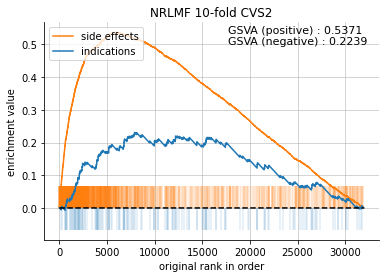

In [7]:
#%% NRLMF
cv_data1 = pd.read_pickle(base_dir + '/Data/cvs_data/simple_CVS2_NRLMF.pkl')
cv_data2 = pd.read_pickle(base_dir + '/Data/cvs_data/simple_CVS2_NRBdMF.pkl')

for seed in cv_data1.keys():
    ix = 0
    for W, test_data, test_label in cv_data1[seed]:
        # load model
        model = nrlmf.NRLMF(cfix=5,K1=5,K2=5,num_factors=50,theta=1.0,lambda_d=0.625,lambda_t=0.625,alpha=0.1,beta=0.1, max_iter=5000,tolx=1e-4,half_mask=False,verbose=True)
        model.fix_model(W, use_se, drugMat=drugMat, targetMat=diseaseMat, seed=seed)
        merged_label = cv_data2[seed][ix][2] # load NRMMF info
        posi_merged_label = np.where(merged_label<1,0,merged_label) # convert 0 and -1 label to 0
        aupr_val, auc_val = model.ex_evaluation(test_data, posi_merged_label)
        
        # enrichment
        res = model.pred_res
        res["merged_label"] = merged_label
        
        y_label = res.sort_values("scores",ascending=False)["merged_label"].tolist()
        p_enr, n_enr = pc.posi_nega_enrichment(y_label=y_label,title="NRLMF 10-fold CVS2",
                                               posi_label="side effects",xlabel="original rank in order",ylabel="enrichment value",verbose=True)
        break

***
#### Summary
- The positive labels for side effects, shown by orange line, are highly enrichmed in both NRBdMF and NRLMF.
- The negative labels for indications, shown by blue line, are oncentrated at the top as well as side effects in the NRLMF while our proposed NRBdMF succeeded in push ing them to the bottom.